# Trend Classification with LSTM

### Imports

In [124]:
import os, sys
import pandas as pd
import numpy as np
from numpy import set_printoptions
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from time import time
from tensorflow.python.keras.callbacks import TensorBoard
import warnings
warnings.simplefilter("ignore")

from indicators import *
from data_loading import *
from util_functions import *


physical_devices = tf.config.list_physical_devices('None')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


### Parameters

In [125]:
trail_size=14
predict_length = 5
time_period = '6y'

# 1.0 Load data

## 1.1 Load stock data

In [126]:
top_energy = ["XOM", "CVX", "RDS-A", "RDS-B", "PTR", "TOT", "BP",
"SNP", "ENB", "COP", "EQNR", "PBR-A", "PBR", "EPD",
"TRP", "E", "EOG", "SLB", "KMI", "PSX", "CNQ",
"MPC", "PXD", "SU", "VLO"]

In [127]:
traditional_energy_stocks = [ "LNG", "OKE", "BKR", "WMB", "EQT",  "XEC",  "XOM",  "CVX",  "BP",  "OXY",  "COP",  "EOG",  "COG",  "CNQ",  "SLB",  "PTR",  "TOT",  "ENB"]

In [128]:
data = get_data_yf(traditional_energy_stocks + top_energy, time_period)

[*********************100%***********************]  33 of 33 completed


In [129]:
data.isna().sum().sum()

0

In [130]:
data = process_stock_data_from_yf(data)

In [131]:
has_data_ratio, data = filter_has_all_data(data)
has_data_ratio

100.0

## 1.2 Compute technical indicators

In [132]:
all_stock_features = ['Close', 'High',
 'Low', 'Open', 'Volume',
 'HH', 'LL', 'AV',
 'SMA', 'SD', 'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 'WMA', 'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 'DX',
 'PDI', 'NDI', 'ADX',
 'ROC', 'MACD', 'CCI']

#all_stock_features = ['Close', 'High', 'Low', 'Open','HH', 'LL','SMA', 'EMA', 'WMA', 'BBHIGH','BBLOW','TRIMA']

#all_stock_features = ['Close', 'High', 'Low', 'Open','HH', 'LL','SMA', 'EMA', 'WMA', 'BBHIGH','BBLOW','TRIMA', 'DX']

#all_stock_features = ['Close', 'High', 'Low', 'Open','Volume', 'AV', 'HH', 'LL','SMA', 'EMA', 'WMA', 'BBHIGH','BBLOW','TRIMA', 'DX']

In [133]:
# compute all our technical markers for each of the stocks. 
dataset = data.groupby('Ticker').apply(lambda x: add_technical_markers(x, trail_size))

## 1.3 Load trends data

In [134]:
filenames = [
    "data climate change adjusted.csv",
    "data greenhouse gas adjusted.csv",
    "data oil adjusted.csv",
    "data renewable adjusted.csv",
    "data carbon tax adjusted.csv",
    "data electric vehicles adjusted.csv",
    "data environmental protection agency adjusted.csv",
    "data fossil fuels adjusted.csv",
    "data fracking adjusted.csv",
    "data global warming adjusted.csv",
]
terms = [
    "climate change",
    "greenhouse gas",
    "oil",
    "renewable",
    "carbon tax",
    "electric vehicles",
    "environmental protection agency",
    "fossil fuels",
    "fracking",
    "global warming",
]

In [135]:
climate_trends_data = load_climate_data(filenames, terms)

In [136]:
climate_trends_data.shape

(2278, 11)

<AxesSubplot:xlabel='Date'>

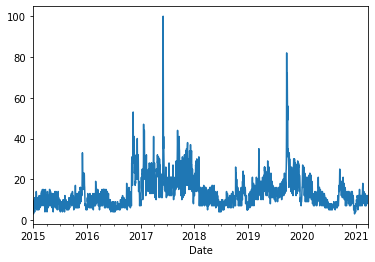

In [137]:
climate_trends_data.set_index('Date')[terms[0]].plot()

### Choose features

In [138]:
chosen_stock_features = all_stock_features

In [139]:
chosen_trend_terms = terms

# 3.0 Model design

In [140]:
num_features = len(chosen_stock_features) + len(chosen_trend_terms) 

In [141]:
model = Sequential()
model.add(LSTM(units=75, input_shape=(trail_size, num_features), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(5, activation='relu'))
model.add(Dropout(0.25))


model.add(Dense(1, activation='sigmoid'))

In [142]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 14, 75)            30300     
_________________________________________________________________
dropout_15 (Dropout)         (None, 14, 75)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 14, 30)            12720     
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 30)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 14, 30)            7320      
_________________________________________________________________
dropout_17 (Dropout)         (None, 14, 30)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 14, 30)           

# 2.0 Prepare dataset of many stocks

In [143]:
x_train, y_train, x_valid, y_valid, x_test, y_test = generate_dataset(dataset, 
                                                                           climate_trends_data,
                                                                           traditional_energy_stocks + top_energy,
                                                                           "2018-03-01", "2019-03-01", "2020-03-01", 
                                                                           chosen_stock_features, chosen_trend_terms,
                                                                            trail_size, predict_length
                                                                           )

In [144]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_valid: {}".format(x_valid.shape))
print("y_valid {}".format(y_valid.shape))
print("x_test: {}".format(x_test.shape))
print("y_test {}".format(y_test.shape))

x_train: (23199, 14, 25)
y_train: (23199,)
x_valid: (7656, 14, 25)
y_valid (7656,)
x_test: (7689, 14, 25)
y_test (7689,)


## 2.1 Train on many stocks

In [145]:
time_stamp = time()
tensorboard = TensorBoard(log_dir='logs/{}'.format(time_stamp))

In [146]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [147]:
history1 = model.fit(x_train, 
                     y_train, 
                     epochs=15, 
                     validation_data=(x_valid, y_valid), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/15
363/363 [==============================] - 19s 53ms/step - loss: 0.6861 - accuracy: 0.5484 - val_loss: 0.6903 - val_accuracy: 0.5283
Epoch 2/15
363/363 [==============================] - 13s 37ms/step - loss: 0.6744 - accuracy: 0.5775 - val_loss: 0.6950 - val_accuracy: 0.5231
Epoch 3/15
363/363 [==============================] - 14s 37ms/step - loss: 0.6579 - accuracy: 0.6071 - val_loss: 0.7190 - val_accuracy: 0.5302
Epoch 4/15
363/363 [==============================] - 15s 42ms/step - loss: 0.6485 - accuracy: 0.6179 - val_loss: 0.6940 - val_accuracy: 0.5308
Epoch 5/15
363/363 [==============================] - 12s 33ms/step - loss: 0.6389 - accuracy: 0.6296 - val_loss: 0.7023 - val_accuracy: 0.5311
Epoch 6/15
363/363 [==============================] - 13s 36ms/step - loss: 0.6242 - accuracy: 0.6471 - val_loss: 0.7304 - val_accuracy: 0.4983
Epoch 7/15
363/363 [==============================] - 14s 39ms/step - loss: 0.6133 - accuracy: 0.6630 - val_loss: 0.7309 - val_accuracy:

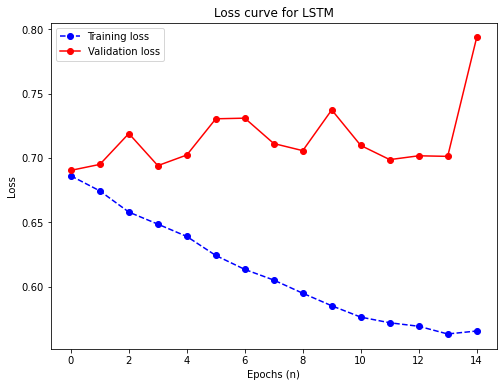

In [148]:
plot_loss(history1)

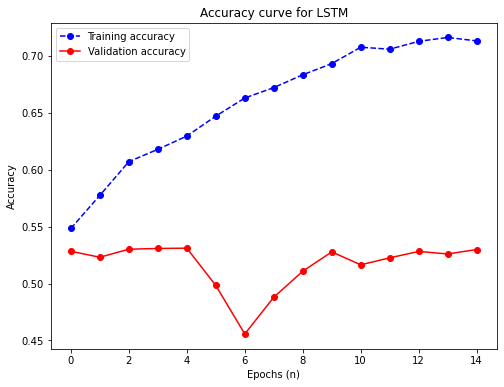

In [149]:
plot_acc(history1)

## 2.2 Performance of model

In [150]:
performance_stats(model, x_train, y_train)

Upward ratio: 50.86%
Mean prediction: 54.15%
Predicted upward ratio: 55.54%
Accuracy: 73.25%


In [151]:
performance_stats(model, x_valid, y_valid)

Upward ratio: 53.02%
Mean prediction: 73.46%
Predicted upward ratio: 99.95%
Accuracy: 52.99%


In [152]:
performance_stats(model, x_test, y_test)

Upward ratio: 47.24%
Mean prediction: 71.40%
Predicted upward ratio: 93.98%
Accuracy: 47.67%


# 3.0 Prepare data for less stocks

In [153]:
x_train2, y_train2, x_valid2, y_valid2, x_test2, y_test2 = generate_dataset(dataset, 
                                                                           climate_trends_data,
                                                                           traditional_energy_stocks,
                                                                           "2018-03-01", "2019-03-01", "2020-03-01", 
                                                                           chosen_stock_features, chosen_trend_terms,
                                                                            trail_size, predict_length
                                                                           )

In [154]:
print("x_train: {}".format(x_train2.shape))
print("y_train: {}".format(y_train2.shape))
print("x_valid: {}".format(x_valid2.shape))
print("y_valid {}".format(y_valid2.shape))
print("x_test: {}".format(x_test2.shape))
print("y_test {}".format(y_test2.shape))

x_train: (12654, 14, 25)
y_train: (12654,)
x_valid: (4176, 14, 25)
y_valid (4176,)
x_test: (4194, 14, 25)
y_test (4194,)


## 3.1 Train model on less stocks

In [155]:
# model.layers[7].trainable = False
# model.layers[4].trainable = False
# model.layers[2].trainable = False
# model.layers[0].trainable = False

In [156]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [157]:
tensorboard = TensorBoard(log_dir='logs/{}_2'.format(time_stamp))

In [158]:
history2 = model.fit(x_train2, 
                     y_train2, 
                     epochs=8, 
                     validation_data=(x_valid2, y_valid2), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/8
198/198 [==============================] - 13s 66ms/step - loss: 0.5555 - accuracy: 0.7284 - val_loss: 0.7059 - val_accuracy: 0.4935
Epoch 2/8
198/198 [==============================] - 8s 40ms/step - loss: 0.5541 - accuracy: 0.7276 - val_loss: 0.7022 - val_accuracy: 0.5172
Epoch 3/8
198/198 [==============================] - 8s 38ms/step - loss: 0.5501 - accuracy: 0.7307 - val_loss: 0.6906 - val_accuracy: 0.5350
Epoch 4/8
198/198 [==============================] - 8s 38ms/step - loss: 0.5459 - accuracy: 0.7278 - val_loss: 0.6929 - val_accuracy: 0.5321
Epoch 5/8
198/198 [==============================] - 8s 40ms/step - loss: 0.5449 - accuracy: 0.7341 - val_loss: 0.6992 - val_accuracy: 0.5235
Epoch 6/8
198/198 [==============================] - 8s 39ms/step - loss: 0.5437 - accuracy: 0.7327 - val_loss: 0.6984 - val_accuracy: 0.5055
Epoch 7/8
198/198 [==============================] - 8s 39ms/step - loss: 0.5412 - accuracy: 0.7324 - val_loss: 0.7209 - val_accuracy: 0.5316
Epoch

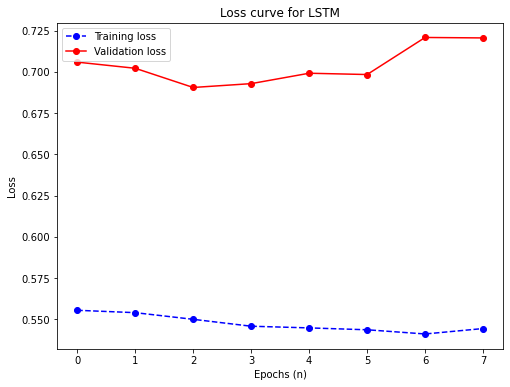

In [159]:
plot_loss(history2)

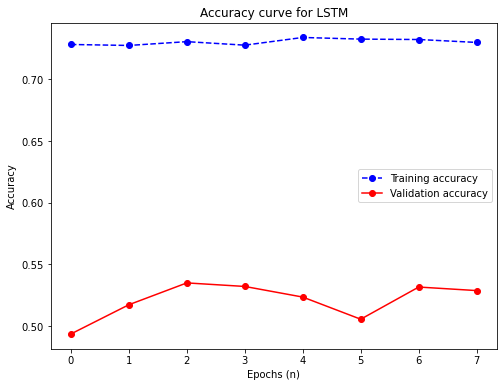

In [160]:
plot_acc(history2)

## 3.2 Performance of model

In [161]:
performance_stats(model, x_train2, y_train2)

Upward ratio: 49.73%
Mean prediction: 51.18%
Predicted upward ratio: 46.89%
Accuracy: 74.37%


In [162]:
performance_stats(model, x_valid2, y_valid2)

Upward ratio: 52.85%
Mean prediction: 63.51%
Predicted upward ratio: 96.77%
Accuracy: 52.87%


In [163]:
performance_stats(model, x_test2, y_test2)

Upward ratio: 47.04%
Mean prediction: 58.20%
Predicted upward ratio: 80.07%
Accuracy: 47.14%
